# 2020-07-20

## Analyzing Rpb1-MS2 movies

I collected some initial movies of embryos with homozygous Rpb1-EGFP and MCP-mCherry together with paternally supplied WT eve MS2. The experiments worked — eve transcription spots and Rpb1 signal with significant structure are both visible. I want to do some analysis on these movies before I 1) share them or 2) collect more data so I can figure out what's going on a little before getting lost in the mire. Kind of racing against the clock.

It seems from my attempts to go through the processing pipeline there are a few problems that demand fixing:


1. There is a problem with the Z-locations of spot-finding. Need to work this out.

3. The "nudging" feature of the spot local movie maker isn't appropriate for using it to do enrichment analysis...need to fix.

1. Nuclear segmentation on Rpb1 doesn't work. The initial mask works great, but the gradient and watershed gets screwed up by the HLB. Will need a custom routine.

### 1. Fixing Z locations in spot finding

In [4]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [28]:
mv = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200716-rd2-em1-zmv-04.pkl')

In [29]:
spm = imp.spot_movies(mv.stack, mv.spot_data,channel=1, len_ij=31, len_z=7)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

In [30]:
viewer(mv.stack)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

In [44]:
mv.fits[8][:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 2., 1., 2., 3., 0., 3., 3., 3., 0., 0., 0., 0., 3., 3., 3.,
       0., 0., 3., 0., 3., 0., 0., 0., 0.])

In [26]:
a=pm.mean(axis=0).mean(axis=0)
viewer(a)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

### Problems in localizing spots

I realized that the way I was correcting positions of spots at the edges of the image was a problem. I tried to fix these within __fit_MS2__ function.

In [45]:
stack = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/2020-07-17/rd2-em1-zmv-04.czi')
nucmask = np.zeros_like(stack[0])

In [58]:
reload(imp)
fits = imp.fit_ms2(stack[1,0:1], peak_window_size=(24,20,20), sigma_small=0.5, 
                   sigma_big=4, bg_radius=4, fitwindow_rad_xy=5, 
                   fitwindow_rad_z=5)

In [67]:
spot_data = imp.filter_ms2fits(stack[1,0:1], fits, xy_max_width=10)
spot_data = imp.connect_ms2_frames(spot_data, nucmask)
boxed = imp.box_spots(stack[1], spot_data, halfwidth_z=0, shadows=False)

In [68]:
viewer(boxed)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

This looks pretty good and seems to do a good job of getting the right plane. Will run on a few more frames and see where we get.

In [69]:
fits = imp.fit_ms2(stack[1,0:6], peak_window_size=(24,20,20), sigma_small=0.5, 
                   sigma_big=4, bg_radius=4, fitwindow_rad_xy=5, 
                   fitwindow_rad_z=5)

1
2
3
4
5


In [72]:
spot_data = imp.filter_ms2fits(stack[1,0:6], fits, xy_max_width=10)
spot_data = imp.connect_ms2_frames(spot_data, nucmask)
spot_data = imp.filter_spot_duration(spot_data, 5)
boxed = imp.box_spots(stack[1], spot_data, halfwidth_z=1, shadows=False)
viewer(boxed)

1
2
3
4
5


interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

In [111]:
reload(imp)
a=imp.spot_movies(stack, spot_data,channel=1, len_ij=31,view=False)

### Remove nudging from spot_movies function

In [145]:
test = a[18][0]
viewer(np.nanmean(a, axis=1))

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

In [149]:
reload(imp)
b=imp.spot_movies(stack, spot_data,channel=1, len_ij=31,view=True)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

### Nuclear masking issues

Going to make a new nuclear masking routine for rpb1 specifically.

In [270]:
from imagep import dog_filter, imfill, peak_local_max_nD, gradient_nD, labelmask_filter_objsize, relabel_labelmask, labelmask_apply_morphology
from skimage.filters.thresholding import threshold_li, threshold_otsu
from skimage.segmentation import flood_fill, watershed

def segment_nuclei3D_monolayer_rbp1(stack, sigma1=3, sigma_dog_big=15, 
        sigma_dog_small=5, sigma_dog2_big=20, sigma_dog2_small=15, 
        seed_window=(30,30), min_seed_dist=25, 
        dilation_length=5, size_min=0, size_max=np.inf, display=False):
    """Segment nuclei from confocal nuclear monolayers
    
    Segment nuclei from nuclear monolayers, such as standard MS2 confocal
    stacks. Monolayers don't generally require 3D segmentation, so this
    function uses the max projection in Z to define the domain of each 
    nucleus in XY. 
    
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma1: int
            Sigma for Gaussian smoothing used to make gradient input to watershed
        sigma_dog_small: int
            Smaller sigma for DoG filter used to create initial mask
        sigma_dog_big: int
            Larger sigma for DoG filter used to create initial mask
        seed_window: tuple of three ints
            Size in [z, x, y] for window for determining local maxes in distance
            transform. Generally want size to be ~ size of nuclei.
        min_seed_dist: numeric
            The minimum euclidean distance (in pixels) allowed between watershed
            seeds. Typically set as ~the diameter of the nuclei.
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        dilation_length: int
            Size in x and y of structuring element for dilating objects after
            final segmentation.
        
    Returns:
        labelmask: ndarray
            2D labelmask of nuclei.
    """
    # Make max projection on Z.
    maxp = stack.max(axis=0)
    # Filter with DoG to make nuclei into blobs.
    #dog = dog_filter(maxp, sigma_dog_small, sigma_dog_big)
    smooth = ndi.gaussian_filter(maxp, sigma1)
    # Get threshold, use thresh to make initial mask and fill holes.
    t = threshold_otsu(smooth)
    mask = np.where(smooth > t, 1, 0)
    mask = imfill(mask)
    t_hlb = threshold_otsu(smooth[mask.astype('bool')])
    smooth[smooth > t_hlb] = 0
    return smooth
    # Perform distance transform, find local maxima for watershed seeds.
    dist = ndi.distance_transform_edt(mask)
    seeds, _ = peak_local_max_nD(dist, size=seed_window, min_dist=min_seed_dist)
    # Smooth image and take gradient, use as input for watershed.
    #im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
    dog2 = dog_filter(maxp, sigma_dog2_small, sigma_dog2_big)
    grad = gradient_nD(dog2)
    ws = watershed(grad, seeds.astype(int))
    # Filter object size, relabel to set background to 0.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    labelmask = relabel_labelmask(labelmask)
    # Dilate segmented nuclei.
    labelmask = labelmask_apply_morphology(labelmask, 
                    mfunc=ndi.morphology.binary_dilation, 
                    struct=np.ones((dilation_length, dilation_length)), 
                    expand_size=(dilation_length + 1, dilation_length + 1))

    if (display):
        fig, ax = plt.subplots(3,2, figsize=(10,10))
        # Display mask.
        ax[0][0].imshow(mask)
        ax[0][0].set_title('Initial Mask')
        # Display watershed seeds.
        seeds_vis = ndi.morphology.binary_dilation(seeds, structure=np.ones((8,8)))
        ax[0][1].imshow(dog2, alpha=0.5)
        ax[0][1].imshow(seeds_vis, alpha=0.5)
        ax[0][1].set_title('Watershed seeds')
        # Display gradient.
        ax[1][0].imshow(grad)
        ax[1][0].set_title('Gradient')
        # Display watershed output.
        ws = relabel_labelmask(ws)
        ax[1][1].imshow(ws.astype('bool'))
        ax[1][1].set_title('Watershed')
        # Display final mask.
        ax[2][0].imshow(labelmask.astype('bool'))
        ax[2][0].set_title('Final Segmentation')
    
    # Make 2D labelmask into 3D mask by repeating.
    labelmask = np.repeat([labelmask], stack.shape[0], axis=0)
    return labelmask

a=segment_nuclei3D_monolayer_rbp1(stack[0,0], seed_window=(40,40), sigma_dog2_big=25, sigma_dog2_small=20, size_max=5000, dilation_length=15, display=True)
viewer(a)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

(array([4.2856e+04, 7.1763e+04, 5.7640e+03, 1.0010e+03, 5.6400e+02,
        3.9800e+02, 2.6200e+02, 2.2900e+02, 1.1800e+02, 3.6000e+01]),
 array([  498. ,  7001.7, 13505.4, 20009.1, 26512.8, 33016.5, 39520.2,
        46023.9, 52527.6, 59031.3, 65535. ]),
 <a list of 10 Patch objects>)

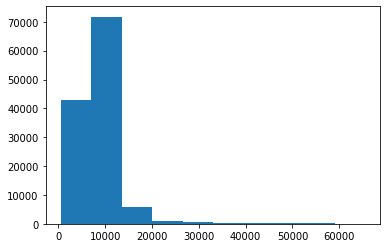

In [265]:
plt.hist(test[a.astype('bool')])

In [188]:
viewer(imp.dog_filter(maxp, 20,25))

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

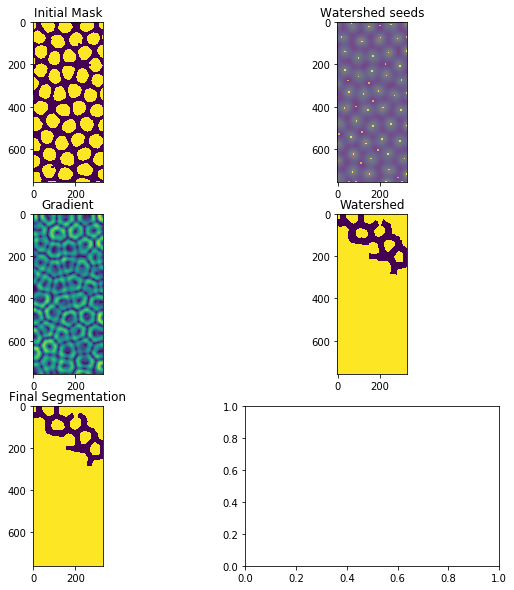

In [180]:
a=segment_nuclei3D_monolayer_rbp1(stack[0,0], display=True)

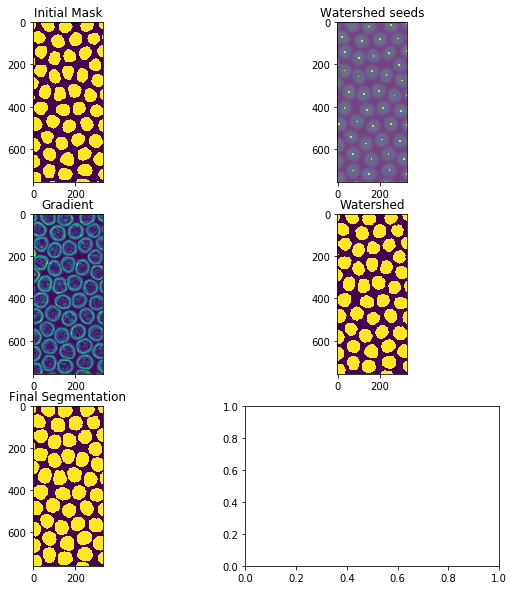

In [195]:


a = imp.segment_nuclei3D_monolayer(stack[0,0,5:], seed_window=(40,40), size_max=5000, dilation_length=5, display=True)





Hmmm, so I can just find a slice that doesn't have the HLBs and do the segmentation on that. Not sure if this is a robust or durable solution. I wonder if I can pre-mask the HLB?

In [200]:
test = stack[0,0,3]
viewer(test)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

In [244]:
viewer(dog_filter(test,3,0.01),figsize=12)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

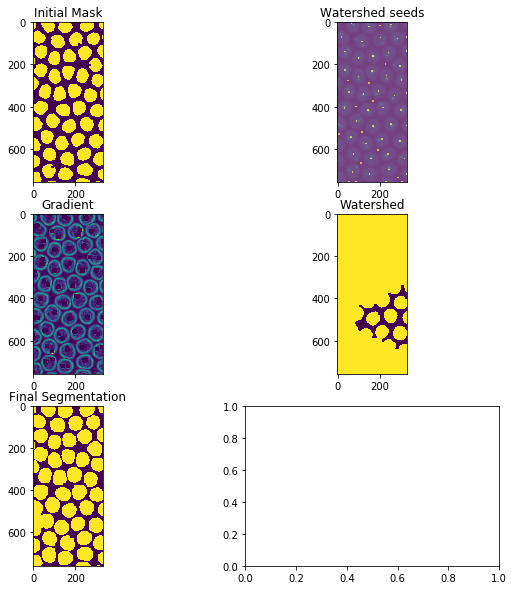

In [315]:
from imagep import filter_labelmask, object_circularity

def segment_nuclei3D_monolayer_rbp1(stack, sigma1=3, sigma_dog_big=15, 
        sigma_dog_small=5, seed_window=(30,30), min_seed_dist=25, 
        dilation_length=5, dilation_length_foci=10, size_min=0, circularity_min=0, size_max=np.inf, 
        display=False):
    """Segment nuclei from confocal nuclear monolayers
    
    Segment nuclei using Rpb1 signal. The segment_nuclei3D_monolayer function runs
    into problems because of the strong Rpb1 foci (presumed histone locus bodies)
    that create problems in the gradient used as input for watershed segmentation.
    This function has an additional masking step that segments these foci and masks
    them out of the gradient image, and also adds an object circularity filter.
    
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma1: int
            Sigma for Gaussian smoothing used to make gradient input to watershed
        sigma_dog_small: int
            Smaller sigma for DoG filter used to create initial mask
        sigma_dog_big: int
            Larger sigma for DoG filter used to create initial mask
        seed_window: tuple of three ints
            Size in [z, x, y] for window for determining local maxes in distance
            transform. Generally want size to be ~ size of nuclei.
        min_seed_dist: numeric
            The minimum euclidean distance (in pixels) allowed between watershed
            seeds. Typically set as ~the diameter of the nuclei.
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        dilation_length: int
            Size in x and y of structuring element for dilating objects after
            final segmentation.
        dilation_length_foci: int
            Size in x and y of structuring element for dilating nuclear foci (HLB)
            mask.
        circularity_min: float 0 to 1
            Minimum circularity for objects to be retained in final mask
        
    Returns:
        labelmask: ndarray
            2D labelmask of nuclei.
    """
    # Make max projection on Z.
    maxp = stack.max(axis=0)
    # Filter with DoG to make nuclei into blobs.
    dog = dog_filter(maxp, sigma_dog_small, sigma_dog_big)
    # Get threshold, use thresh to make initial mask and fill holes.
    t = threshold_otsu(dog)
    mask = np.where(dog > t, 1, 0)
    mask = imfill(mask)
    # Perform distance transform, find local maxima for watershed seeds.
    dist = ndi.distance_transform_edt(mask)
    seeds, _ = peak_local_max_nD(dist, size=seed_window, min_dist=min_seed_dist)
    # Smooth image and take gradient, use as input for watershed.
    im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
    grad = gradient_nD(im_smooth)
    # Make second mask of pol2 foci (presumed HLBs) by re-thresholding within nuclei.
    t_foci = threshold_otsu(im_smooth[mask.astype('bool')])
    mask_foci = np.where(im_smooth > t_foci, True, False)
    mask_foci = ndi.morphology.binary_dilation(mask_foci, structure=np.ones((dilation_length_foci, dilation_length_foci)))
    # Mask out pol2 foci in gradient.
    grad = np.where(mask_foci, 0, grad)
    # Perform watershed segmentation.
    ws = watershed(grad, seeds.astype(int))
    # Filter object size and circularity, relabel to set background to 0.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    # Note: object_circularity works on 3D labelmasks, requiring adding (expand_dims) and removing (squeeze) a dimension.
    labelmask = np.squeeze(filter_labelmask(np.expand_dims(labelmask, axis=0), object_circularity, circularity_min, 1000))
    labelmask = relabel_labelmask(labelmask)
    # Dilate segmented nuclei.
    labelmask = labelmask_apply_morphology(labelmask, 
                    mfunc=ndi.morphology.binary_dilation, 
                    struct=np.ones((dilation_length, dilation_length)), 
                    expand_size=(dilation_length + 1, dilation_length + 1))

    if (display):
        fig, ax = plt.subplots(3,2, figsize=(10,10))
        # Display mask.
        ax[0][0].imshow(mask)
        ax[0][0].set_title('Initial Mask')
        # Display watershed seeds.
        seeds_vis = ndi.morphology.binary_dilation(seeds, structure=np.ones((8,8)))
        ax[0][1].imshow(im_smooth, alpha=0.5)
        ax[0][1].imshow(seeds_vis, alpha=0.5)
        ax[0][1].set_title('Watershed seeds')
        # Display gradient.
        ax[1][0].imshow(grad)
        ax[1][0].set_title('Gradient')
        # Display watershed output.
        ws = relabel_labelmask(ws)
        ax[1][1].imshow(ws.astype('bool'))
        ax[1][1].set_title('Watershed')
        # Display final mask.
        ax[2][0].imshow(labelmask.astype('bool'))
        ax[2][0].set_title('Final Segmentation')
    
    # Make 2D labelmask into 3D mask by repeating.
    labelmask = np.repeat([labelmask], stack.shape[0], axis=0)
    return labelmask
test = stack[0,0]
a=segment_nuclei3D_monolayer_rbp1(test, size_max=6000, circularity_min=0.5 ,display=True)

In [316]:
viewer(a)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'gray_r', 'viridis', 'prism', …

Great success. This seems to work fine. I committed it and will process now.

Processed 20200717-rd2-em1-zmv-04:

In [5]:
mv = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-04.pkl')

In [26]:
spots_v = imp.spot_movies(mv.stack, mv.spot_data, 1, fill=0, len_ij=25)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [13]:
viewer(spots_v.mean(axis=1))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [14]:
spots_vp = imp.spot_movies(mv.stack, mv.spot_data, 0, fill=0)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [17]:
viewer([spots_vp.mean(axis=1), spots_v.mean(axis=1)])

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

OK, this looks pretty good. There are still a few empty spots...

In [18]:
mv.spot_data[31]

array([[7.00000000e+00, 3.40000000e+01, 4.00000000e+00, 4.79000000e+02,
        2.33000000e+02, 9.88596075e+02, 5.35150592e+00, 7.59917228e+00,
        6.66111408e+00, 6.90568493e+03, 9.03410313e+02, 1.35458904e+03],
       [8.00000000e+00, 3.40000000e+01, 5.00000000e+00, 4.84000000e+02,
        2.41000000e+02, 1.41287503e+03, 3.16275338e+00, 5.88185017e+00,
        4.41175066e+00, 7.55054795e+03, 1.17018602e+03, 1.82331507e+03],
       [9.00000000e+00, 3.40000000e+01, 5.00000000e+00, 4.84000000e+02,
        2.37000000e+02, 1.06170640e+03, 4.21242491e+00, 6.04792986e+00,
        7.37276611e+00, 6.20535616e+03, 9.52492507e+02, 1.56341096e+03],
       [1.00000000e+01, 3.40000000e+01, 5.00000000e+00, 4.82000000e+02,
        2.34000000e+02, 1.07674291e+03, 4.84657808e+00, 6.58473961e+00,
        6.28225885e+00, 7.37634247e+03, 9.65361462e+02, 1.60338356e+03],
       [1.10000000e+01, 3.40000000e+01, 5.00000000e+00, 4.84000000e+02,
        2.31000000e+02, 1.09120363e+03, 5.03178281e+00, 5.89

In [59]:
reload(imp)
imp.quickview_ms2(mv.stack, mv.spot_data, 0,'all',10)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [28]:
viewer(spots_v.max(axis=2))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

OK playing around with the above two convinces me that the movie function (and the fits behind it) are now working. The data in the spot-centered boxes matches the data in the original movie.

A couple observations:

1. The HLB present a problem with the enrichment analysis. Some care will have to be taken to avoid including them in the averages since that would screw everything up. I can see some kind of curation or a masking approach. To start with, using nc14 data in which the spots are separated physically from the bodies seems useful.

2. There's huge variation in spot intensities, so that could be an interesting factor in looking for enrichment. Would be great to have some green histone controls.

I'm going to start with a manual curation of spots that are bright and not apparently near the HLB:

In [34]:
viewer([spots_vp.max(axis=1), spots_v.max(axis=1)])

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [44]:
curated_spots = [3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,22,25,29,30,31,32,33]

In [45]:
curated_data = {x: mv.spot_data[x] for x in curated_spots}

In [248]:
reload(imp)
spots_v = imp.spot_movies(mv.stack, curated_data, 1, fill=0, len_ij=31, view=False)
spots_vp = imp.spot_movies(mv.stack, curated_data, 0, fill=0, len_ij=31, view=False)

In [259]:
viewer(spots_v.sum(axis=1).sum(axis=0))     

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [260]:
viewer(spots_vp.sum(axis=1).sum(axis=0))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [56]:
viewer([mv.stack[0],mv.stack[1]])

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

This is promising. The Rpb1 shows a strong enrichment signal at the ms2 spot. Of course, there's the nucleus problem. Looking at the slices above and below makes it unlikely that I'm just seeing these edge effects, but of course I'll need to correct/control for it explicitly. I like the idea of get the signal for every pixel in the nucleus, but the Rpb1 spots create an issue. I selected spots that are not near Rpb1, so I would need to do that for controls. I could use the masking I used for nuclear segmentation...

How's this:

1. Mask HLBs out of nuclear mask (with significant dilation to avoid anything close).
2. Write something that takes the nuclear pixels that are remaining and derives an average "enrichment" signal.

OK, gonna do that now.

In [113]:
from skimage.filters.thresholding import threshold_li, threshold_otsu

def mask_rpb1_foci(stack, mask, sigma1=3, dilation_len=10):
    mask_foci = np.zeros_like(stack)
    for i in range(0, stack.shape[0]):
        maxp = stack[i].max(axis=0)
        im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
        # Make second mask of pol2 foci (presumed HLBs) by re-thresholding within nuclei.
        t_foci = threshold_otsu(im_smooth[mask[i,0].astype('bool')])
        mask_2d = np.where(im_smooth > t_foci, True, False)
        mask_2d = ndi.morphology.binary_dilation(mask_2d, structure=np.ones((dilation_len, dilation_len)))
        mask_3d = np.repeat([mask_2d], stack.shape[1], axis=0)
        mask_foci[i] = mask_3d
    return mask_foci.astype('bool')

a=mask_rpb1_foci(mv.stack[0], mv.nucmask)

In [183]:
mv.stack[0].shape
viewer(np.where(a, 0, mv.nucmask))



interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

OK, foci effectively masked. Now we need to go through 

In [118]:
viewer(np.where(mv.nucmask, mv.stack[0],0))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [203]:
from random import random
def random_spot_data(spot_data, mask, n):
    rand_spot_data = {}
    for spot in spot_data:
        #print(type(rand))
        #print(spot)
        #rand[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rand_spot_data[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rownum=0
        arr = spot_data[spot]
        for row in arr:
            t, nuc, z = [int(x) for x in row[0:3]]
            x,y = np.where(mask[t,z] == nuc)
            numpix = len(x)
            for i in range(0, n):
                rand = int(numpix * random())
                randx, randy = x[rand], y[rand]
                newrow = row.copy()
                newrow[3:5] = [randx, randy]
                #rand_spot_data[spot] = np.vstack((rand_spot_data[spot], [newrow]))
                rand_spot_data[spot][rownum] = newrow
                rownum = rownum + 1
    return rand_spot_data
e=random_spot_data(mv.spot_data, np.where(a, 0, mv.nucmask),2)

In [ ]:
viewer(np.where())

In [177]:
imp.quickview_ms2(mv.stack, mv.spot_data, 0, 7,6)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [208]:
imp.quickview_ms2(np.expand_dims(mv.nucmask.astype(np.uint16), axis=0), e, 0, 'all',6)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [205]:
viewer(mv.nucmask[0])

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [199]:
reload(imp)
rspots_v = imp.spot_movies(mv.stack, e, 1, fill=0, len_ij=31, view=False)
rspots_vp = imp.spot_movies(mv.stack, e, 0, fill=0, len_ij=31, view=False)

In [200]:
viewer(rspots_v.sum(axis=1).sum(axis=0))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [201]:
viewer(rspots_vp.sum(axis=1).sum(axis=0))

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

In [249]:
testrand = rspots_vp.sum(axis=1).sum(axis=0)
testreal = spots_vp.sum(axis=1).sum(axis=0)
testreal.shape

(7, 31, 31)

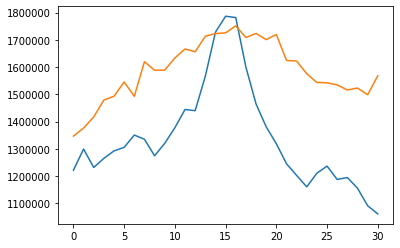

In [251]:
plt.plot(testreal[3,15])
plt.plot(testrand[3,15])

In [261]:
viewer(testrand)

interactive(children=(Dropdown(description='Color', index=1, options=('plasma', 'viridis', 'gray', 'magma', 'g…

It looks like there's pol2 at the spot. That's pretty cool. I think I need to look through the movies manually and make notes.

### Playing with spot detection

Still not super happy with spot detection. Relies heavily on filtering for duration, and it would be better to improve on the single-frame detection. First thing is to see if Z-width is a useful thing to add:

In [277]:
mv.spot_data[4][:,6]

array([ 1.09888553,  0.57913915,  0.75131416,  0.7556341 ,  4.83801681,
        0.66456951,  3.6508865 , 10.97447456, 11.93256807,  6.52179118,
        5.85517668,  4.58072757,  4.38942067,  4.67895136,  5.37212896,
        4.6458809 , 10.65498626, 13.30020203])

(0, 10000.0)

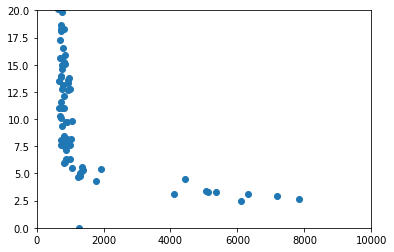

In [294]:
f=0
plt.scatter(mv.fits[f][:,3], mv.fits[f][:,5])
plt.ylim(0,20)
plt.xlim(0,1e4)


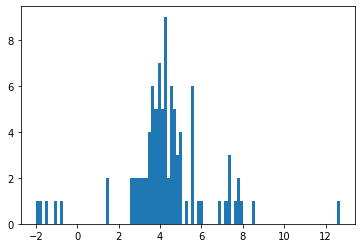

In [302]:
plt.hist(np.log(mv.fits[f][:,3] / mv.fits[f][:,5]), bins=100);

In [300]:
np.log(mv.fits[f][:,5] / mv.fits[f][:,3])

array([ -4.69688354,   1.0149783 ,  -2.66265941,  -4.21332564,
        -3.84516479,  -1.40988437,  -3.33054829,  -3.34523562,
        -3.71059616,  -4.29592112,   0.69801342,  -3.7835213 ,
        -3.44752582,  -2.80109351,  -4.69974582,  -3.44129497,
        -4.10909596,  -3.48838804,  -3.27511419,  -4.25829144,
        -3.71242503,  -2.77828276,  -3.90586808,  -4.5399493 ,
        -4.23545372,  -4.57611743,  -4.48937459,  -3.96542141,
         1.71674692,  -4.66480472,   2.00309062,  -4.83327912,
        -4.29975757,  -4.23293226,  -3.79731863,  -3.92717522,
        -4.74275275,  -4.34262048,  -4.48661445,  -4.06462703,
        -3.96669498,  -4.88325579,  -4.55678103,  -4.26550386,
        -3.08781556,  -3.53019058,  -4.71282994,  -4.24486346,
        -3.63159491,  -3.96674641,  -4.58772159,  -3.82464991,
       -12.70515921,  -4.23753313,  -5.88151316,  -5.56358126,
        -3.96966591,  -7.38835541,  -4.93770621,  -5.58456158,
        -5.50046944,  -4.81828591,  -7.34617533,  -7.81

Going to start a fresh notebook.